In [ ]:
# --- Imports ---
# scipy.stats.norm: CDF for Black-Scholes d2 probability
# data_manager: Binance klines + Polymarket S3 orderbook loaders
# backtest: binary token backtester (proportional / fixed sizing)
from data_manager import BinanceManager, PolymarketManager
from scipy.stats import norm

from backtest import backtest, backtest_fixed, backtest_summary  # noqa: F401

# --- Configuration ---
FREQ = "15M"  # Options: "5M", "15M", "1H", "4H", "1D"
ASSET = "BTC"
START_DATE = "2026-01-01"
END_DATE = "2026-03-31"

FREQ_CONFIG = {
    "5M": {"resample": "5min", "minutes": 5},
    "15M": {"resample": "15min", "minutes": 15},
    "1H": {"resample": "1h", "minutes": 60},
    "4H": {"resample": "4h", "minutes": 240},
    "1D": {"resample": "1D", "minutes": 1440},
}
freq_minutes = FREQ_CONFIG[FREQ]["minutes"]
resample_rule = FREQ_CONFIG[FREQ]["resample"]

In [2]:
# --- Binance 1m klines (BTCUSDT perpetual) ---
# Fetches USDT-margined perpetual 1-minute OHLCV from Binance Futures API.
# Data is cached to ./data/ as CSV; subsequent runs only fetch new candles.
# Used later as spot price (S) and realized volatility input for the BS model.
binance = BinanceManager(base_dir="./data")
btc_klines = binance.fetch_klines("usdm", "BTCUSDT", "1m", start=START_DATE)

In [3]:
# --- Polymarket binary option orderbook (1-min snapshots from S3) ---
# Downloads Up-token orderbook snapshots from a private S3 bucket.
# Parquet files are cached locally; only missing windows are fetched on re-run.
#
# book_df columns:
#   start_time / end_time  - window boundaries
#   up_best_bid/ask, down_best_bid/ask - best level-1 quotes
#   up_mid / down_mid     - mid prices (bid+ask)/2
#   window_close_up_mid   - last observed up mid before window settles
#   resolved              - settlement outcome: 'UP' / 'DOWN' / 'UNKNOWN'
pm = PolymarketManager(base_dir="./data")
book_df = pm.load_book_df(
    asset=ASSET, freq=FREQ, start_date=START_DATE, end_date=END_DATE, log=True
)
book_df

[1/5] Cache: 51,300 rows, 3420 windows | Gaps: 48 days  (1.0s)
[2/5] Listed 0 keys, 0 to fetch  (3.9s)
[2/5] Cache hit windows: 0, time-parse-fail: 0
[3/5] Nothing to download
[4/5] Parsed 0 new rows  (0.0s)
[5/5] No new data, serving from cache  (total 4.9s)


,start_time,end_time,up_best_bid,up_best_ask,up_best_bid_size,up_best_ask_size,down_best_bid,down_best_ask,up_mid,down_mid,window_close_up_mid,resolved
datetime,,,,,,,,,,,,
2026-01-04 18:30:00,2026-01-04 18:30:00,2026-01-04 18:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UP
2026-01-04 18:31:00,2026-01-04 18:30:00,2026-01-04 18:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UP
2026-01-04 18:32:00,2026-01-04 18:30:00,2026-01-04 18:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UP
2026-01-04 18:33:00,2026-01-04 18:30:00,2026-01-04 18:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UP
2026-01-04 18:34:00,2026-01-04 18:30:00,2026-01-04 18:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UP
...,...,...,...,...,...,...,...,...,...,...,...,...
2026-02-14 10:25:00,2026-02-14 10:15:00,2026-02-14 10:30:00,0.44,0.45,456.28,24.30,0.55,0.56,0.445,0.555,NaN,DOWN
2026-02-14 10:26:00,2026-02-14 10:15:00,2026-02-14 10:30:00,0.41,0.42,250.51,63.21,0.58,0.59,0.415,0.585,NaN,DOWN
2026-02-14 10:27:00,2026-02-14 10:15:00,2026-02-14 10:30:00,0.15,0.16,83.40,277.66,0.84,0.85,0.155,0.845,NaN,DOWN


In [4]:
# --- Feature engineering: Black-Scholes d2 probability ---
# Estimates fair probability of each window settling UP using the BS model.
#   S = current spot price (1m open)
#   K = strike = spot at window open (resampled & forward-filled)
#   T = minutes remaining until window expiry
#   sigma = realized log-return vol, scaled by 1/sqrt(T) for term adjustment
#   d2 = (ln(S/K) - 0.5*sigma^2*T) / (sigma*sqrt(T))
#   up_token_prob = N(d2)  -- normal CDF of d2
import numpy as np

features = btc_klines.copy(deep=True)[START_DATE:]
features["S"] = features["open"]
features["K"] = features["open"].resample(resample_rule).first()
features["K"] = features["K"].ffill(limit=freq_minutes)

# Universal T calculation: works for all timeframes (5M through 1D)
minutes_into_day = features.index.hour * 60 + features.index.minute
features["T"] = freq_minutes - (minutes_into_day % freq_minutes)

features["r_vol"] = np.log(features["open"]).diff().rolling(window=freq_minutes).std()
features["adj_term"] = 1 / np.sqrt(features["T"])

S = features["S"]
K = features["K"]
T = features["T"]
sigma = (features["r_vol"] * features["adj_term"]) * 2
d2 = (np.log(S / K) - (0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
features["up_token_prob"] = norm.cdf(d2)
features["down_token_prob"] = 1 - features["up_token_prob"]
features

,open,high,low,close,volume,close_time,quote_asset_volume,num_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore,S,K,T,r_vol,adj_term,up_token_prob,down_token_prob
open_time,,,,,,,,,,,,,,,,,,
2026-01-01 00:00:00,87608.3,87614.9,87600.0,87614.9,186.012,2026-01-01 00:00:59.999000+00:00,1.629507e+07,1279,52.181,4.571307e+06,0,87608.3,87608.3,15,NaN,0.258199,NaN,NaN
2026-01-01 00:01:00,87614.8,87658.0,87614.8,87658.0,34.540,2026-01-01 00:01:59.999000+00:00,3.026847e+06,921,26.914,2.358599e+06,0,87614.8,87608.3,14,NaN,0.267261,NaN,NaN
2026-01-01 00:02:00,87658.0,87658.0,87643.0,87650.1,16.334,2026-01-01 00:02:59.999000+00:00,1.431680e+06,574,7.681,6.732326e+05,0,87658.0,87608.3,13,NaN,0.277350,NaN,NaN
2026-01-01 00:03:00,87650.1,87669.8,87650.0,87669.8,24.693,2026-01-01 00:03:59.999000+00:00,2.164643e+06,581,23.132,2.027806e+06,0,87650.1,87608.3,12,NaN,0.288675,NaN,NaN
2026-01-01 00:04:00,87669.8,87671.7,87669.6,87671.6,27.587,2026-01-01 00:04:59.999000+00:00,2.418558e+06,465,23.821,2.088394e+06,0,87669.8,87608.3,11,NaN,0.301511,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-02-14 17:06:00,69711.1,69711.2,69629.0,69642.6,53.665,2026-02-14 17:06:59.999000,3.738114e+06,3019,29.985,2.088507e+06,0,69711.1,69731.2,9,0.000678,0.333333,0.415578,0.584422
2026-02-14 17:07:00,69642.6,69684.3,69634.5,69634.5,44.049,2026-02-14 17:07:59.999000,3.068555e+06,2033,31.766,2.213021e+06,0,69642.6,69731.2,8,0.000722,0.353553,0.189049,0.810951
2026-02-14 17:08:00,69634.5,69634.5,69585.0,69620.0,178.864,2026-02-14 17:08:59.999000,1.244998e+07,4484,115.466,8.037069e+06,0,69634.5,69731.2,7,0.000508,0.377964,0.085815,0.914185


In [5]:
# --- Backtest: momentum signal near expiry ---
# Signal logic:
#   Buy UP  token when up_mid  > 0.7 in the last 25% of the window
#   Buy DOWN token when down_mid > 0.7 in the last 25% of the window
#
# backtest() parameters:
#   initial_balance - starting capital ($)
#   bet_pct         - fraction of balance risked per window (0.01 = 1%)
#   fee             - apply Polymarket variable fee (0.25 * (p*(1-p))^2)
#   slippage_bps    - execution slippage in basis points (5 = 0.05%)
#
# Alternative: backtest_fixed() uses a constant dollar bet_size per signal.
signal_window = max(1, freq_minutes // 4)  # last 25% of window
up_cond = (book_df["up_mid"] > 0.7) & (features["T"] <= signal_window)
down_cond = (book_df["down_mid"] > 0.7) & (features["T"] <= signal_window)

up_cond = up_cond.reindex(book_df.index)
down_cond = down_cond.reindex(book_df.index)

trades = backtest(
    book_df,
    up_condition=up_cond,
    down_condition=down_cond,
    initial_balance=1000,
    bet_pct=0.01,
    fee=True,
    slippage_bps=5,
)

metrics = backtest_summary(trades)
metrics

,resolved,total_trades,up_trades,dn_trades,up_avg_entry,dn_avg_entry,up_pnl,dn_pnl,total_pnl,cum_pnl,drawdown,win,win_rate
end_time,,,,,,,,,,,,,
2026-01-04 18:45:00,UP,1,1,0,0.910455,NaN,0.965268,0.000000,0.965268,0.965268,0.000000,True,1.000000
2026-01-04 19:00:00,DOWN,3,0,3,NaN,0.850425,0.000000,5.213571,5.213571,6.178839,0.000000,True,1.000000
2026-01-04 19:30:00,UP,1,1,0,0.960480,NaN,0.410230,0.000000,0.410230,6.589069,0.000000,True,1.000000
2026-01-04 19:45:00,DOWN,2,0,2,NaN,0.910455,0.000000,1.952469,1.952469,8.541538,0.000000,True,1.000000
2026-01-04 20:30:00,UP,1,1,0,0.910455,NaN,0.973513,0.000000,0.973513,9.515052,0.000000,True,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-02-14 09:30:00,DOWN,2,0,2,NaN,0.970485,0.000000,0.676035,0.676035,116.688532,281.180500,True,0.890356
2026-02-14 09:45:00,UP,2,2,0,0.975487,NaN,0.558413,0.000000,0.558413,117.246945,280.622086,True,0.890400
2026-02-14 10:00:00,DOWN,1,0,1,NaN,0.780390,0.000000,3.038926,3.038926,120.285872,277.583160,True,0.890444


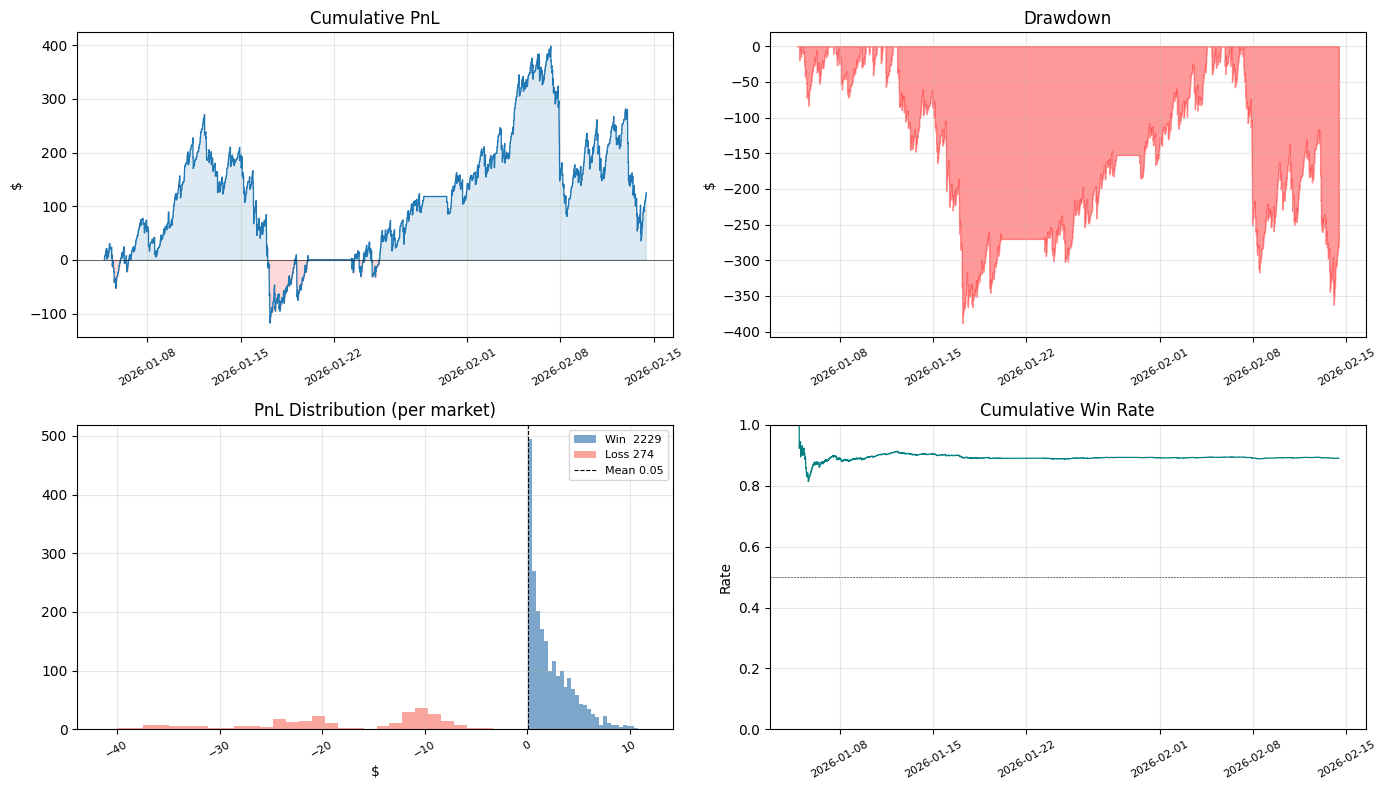

Markets: 2503 | PnL: $125.17 | Win Rate: 89.1% | Sharpe/Mkt: 0.007 | Max DD: $387.92


In [6]:
# --- Performance dashboard ---
# Panel interpretation:
#   [0,0] Cumulative PnL  - equity curve; flat regions = S3 data gaps
#   [0,1] Drawdown        - peak-to-trough decline in dollar terms
#   [1,0] PnL Distribution - per-market win/loss histogram; mean shown as dashed line
#   [1,1] Win Rate         - expanding (cumulative) win rate over time
#
# Summary stats printed below:
#   Sharpe/Mkt = mean(pnl) / std(pnl) per market (not annualized)
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
idx = metrics.index

ax = axes[0, 0]
ax.plot(idx, metrics["cum_pnl"].values, linewidth=0.9, drawstyle="steps-post")
ax.axhline(0, color="k", linewidth=0.4)
ax.fill_between(
    idx,
    metrics["cum_pnl"].values,
    0,
    where=metrics["cum_pnl"].values >= 0,
    alpha=0.15,
    color="C0",
    step="post",
)
ax.fill_between(
    idx,
    metrics["cum_pnl"].values,
    0,
    where=metrics["cum_pnl"].values < 0,
    alpha=0.15,
    color="red",
    step="post",
)
ax.set_title("Cumulative PnL")
ax.set_ylabel("$")
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
dd = metrics["drawdown"].values
ax.fill_between(idx, -dd, 0, color="red", alpha=0.4, step="post")
ax.set_title("Drawdown")
ax.set_ylabel("$")
ax.grid(True, alpha=0.3)

ax = axes[1, 0]
pnl = metrics["total_pnl"]
wins = pnl[pnl > 0]
losses = pnl[pnl <= 0]
ax.hist(wins, bins=30, alpha=0.7, color="steelblue", label=f"Win  {len(wins)}")
ax.hist(losses, bins=30, alpha=0.7, color="salmon", label=f"Loss {len(losses)}")
ax.axvline(pnl.mean(), color="k", linestyle="--", linewidth=0.8, label=f"Mean {pnl.mean():.2f}")
ax.set_title("PnL Distribution (per market)")
ax.set_xlabel("$")
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
ax.plot(idx, metrics["win_rate"].values, linewidth=0.9, color="teal", drawstyle="steps-post")
ax.axhline(0.5, color="k", linestyle="--", linewidth=0.4)
ax.set_title("Cumulative Win Rate")
ax.set_ylabel("Rate")
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3)

for ax in axes.flat:
    ax.tick_params(axis="x", rotation=30, labelsize=8)
    ax.xaxis.set_visible(True)

plt.tight_layout()
plt.show()

n = len(metrics)
total = metrics["total_pnl"].sum()
wr = metrics["win"].mean()
sharpe = (
    metrics["total_pnl"].mean() / metrics["total_pnl"].std()
    if metrics["total_pnl"].std() > 0
    else 0
)
max_dd = metrics["drawdown"].max()
print(
    f"Markets: {n} | PnL: ${total:,.2f} | Win Rate: {wr:.1%} | "
    f"Sharpe/Mkt: {sharpe:.3f} | Max DD: ${max_dd:,.2f}"
)